# Law, Bias, and Algorithms
## Algorithmic fairness (1/2)

In 2016, ProPublica published a [now-famous article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) analyzing and criticizing the lack of fairness in a risk assessment tool used nation-wide called COMPAS.
Here, we will take a look at a cleaned-up version of the COMPAS data that ProPublica used, and try to better understand algorithmic fairness by investigating the claims ProPublica made, along with the [counter claims](https://www.propublica.org/article/technical-response-to-northpointe) made by NorthPointe (now re-branded as [Equivant](https://www.equivant.com/)).

While NorthPointe claims their algorithm does not use race information (anti-classification) as part of their model and their model is calibrated across racial groups (calibration), ProPublica points out that the COMPAS score differ in false positive rates across racial groups (classification parity).
In this notebook, we will examine some of their claims by building and evaluating our own risk assessment tool.

In [14]:
# Some initial setup
options(digits = 3)
library(tidyverse)

theme_set(theme_bw())

# Because huge plots are ugly
options(repr.plot.width = 6, repr.plot.height = 4)

# Read the data
compas_df <- read_rds("../data/compas.rds")

## COMPAS data

A cleaned version of the COMPAS data is loaded as `compas_df`, with the following columns

* `id`: unique identifiers for each case
* `sex`, `dob`, `age`, `race`: demographic information for each defendant
* `recid_score`, `violence_score`: COMPAS scores assessing risk that a defendant will recidivate (`violence_score` for violent crimes) within two years of release (higher score correspond to higher risk)
* `priors_count`: number of prior arrests
* `is_recid`, `is_violent_recid`: Indicator variable that is `1` if the defendant was arrested for a new (violent) crime within two years of release, and `0` otherwise.

In [15]:
head(compas_df)

id,sex,dob,age,race,recid_score,violence_score,priors_count,is_recid,is_violent_recid
<dbl>,<chr>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,Male,1982-01-22,34,African-American,3,1,0,1,1
4,Male,1991-05-14,24,African-American,4,3,4,1,0
5,Male,1993-01-21,23,African-American,8,6,1,0,0
8,Male,1974-07-23,41,Caucasian,6,2,14,1,0
10,Female,1976-06-03,39,Caucasian,1,1,0,0,0
13,Male,1994-06-10,21,Caucasian,3,5,1,1,1


### Exercise 1: Build a risk assessment model for recidivism

We start our exercise by building our own risk assessment tool using only prior arrests (`priors_count`) and age (`age`) to predict whether a defendant is going recidivate within two years of release (`is_recid`).
First, fit a model to estimate the probability of this outcome for each defendant. 
We will call this model `recid_model`.

In [16]:
# Build a logistic regression model estimating recidivism probability

recid_model <- 
# WRITE CODE HERE
# START solution
    glm(is_recid ~ priors_count + age, data = compas_df, family = "binomial")
# END solution

Given an estimate of risk (in probabilities), we can predict whether a defendant will recidivate or not by setting a decision threshold.
Once a threshold is determined, defendants with estimated risk higher or equal to the threshold are predicted to recidivate.
We can then compare the binary prediction to the observed outcome (`is_recid`) to compute the accuracy of our risk assessment tool at the specified threshold.
We can similarly compute accuracy for COMPAS scores (`recid_score`) with some threshold.

As an exercise, calculate the accuracy for the `recid_model` that we fit above at a $50$% threshold, and for the COMPAS recidivism scores at a threshold of $4$.

In [17]:
# WRITE CODE HERE
# START solution
compas_df <- compas_df %>%
    mutate(
        risk = predict(recid_model, type = "response"),
        pred_recid = risk >= 0.5,
        compas_pred_recid = recid_score >= 4
    )

# Calculate accuracy
compas_df %>%
    summarize(
        accuracy = mean(pred_recid == is_recid),
        compas_accuracy = mean(compas_pred_recid == is_recid)
    )
# END solution

accuracy,compas_accuracy
<dbl>,<dbl>
0.675,0.643


### Exercise 2: Calibration

We next examine how well our model is calibrated accorss different race groups (i.e., for people who receive similar risk scores within each race group, what is the actual rate of recidivism.)

To do so, we calculate two quantities:
* `predicted_risk_score`: a discretized (rounded) version of our predicted risk from Exercise 1, similar to the COMPAS risk score;
* `recidivism_rate`: the actual recidivism rate of people within a specific discretized risk score bucket.

Calculate the above two quantities for both racial groups in our dataset by creating a data frame called `calibration_by_race` containing three columns: `race`, `predicted_risk_score`, `recidivism_rate`.

_hint_: `round(x)` will round each element of `x` to the nearest integer.

In [18]:
# Calculate discretized risk score

calibration_by_race <- compas_df %>%
# WRITE CODE HERE
# START solution
    mutate(predicted_risk_score = round(risk * 10)) %>%
    group_by(race, predicted_risk_score) %>%
    summarize(recidivism_rate = mean(is_recid))
# END solution

# Put the recidivism rates of different races side by side
calibration_by_race %>%
    spread(race, recidivism_rate)

predicted_risk_score,African-American,Caucasian
<dbl>,<dbl>,<dbl>
1,0.148,0.150
2,0.266,0.197
3,0.279,0.306
4,0.354,0.398
5,0.472,0.436
6,0.707,0.590
7,0.757,0.790
8,0.788,0.768
9,0.856,0.800


We can also visualize model calibration by plotting the risk score bins with their corresponding emprical recidivism rate:

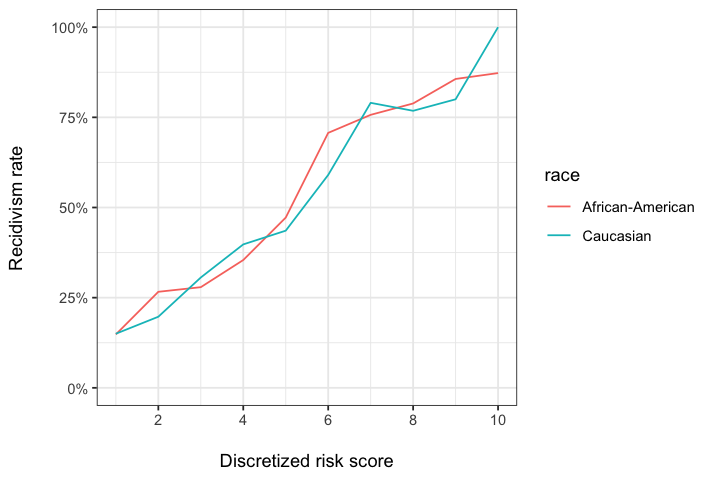

In [19]:
# Calibration plot
ggplot(calibration_by_race, 
       aes(x = predicted_risk_score, y = recidivism_rate, color = race)) +
    geom_line() + 
    scale_y_continuous(labels = scales::percent_format(1), limits = c(0, 1))+
    scale_x_continuous(breaks = seq(0, 10, 2), limits = c(1, 10))+
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

The plot above suggets our model is well calibrated for African-American and Caucasian defendants.
In other words, African-American and Caucasian defendants who receive similar risk scores can be considered to be of similar risk of recidivating.

### Exercise 3: Cost-benefit analysis

Detaining an individual costs a substaintial amount of social resources, yet releasing a defendant will introduce the possibility of a new crime being committed.
Ideally, we would like to detain individuals with high recidivism risk while releasing those with low recidivism risk.
In order to make such a detention policy based on our model, we need to decide on a threshold at which we will determine either detention or release.

Specificially, we would like to estimate for any given detention threshold,
what proportion of crimes will be prevented (i.e., what proportion of defendants that will commit another crime are detained) at what cost (i.e., what proportion of defendants are detained)?

For this exercise, complete the following function which, given a data frame and a threshold, returns a new data frame including two columns: 
* `prop_crime_prevented`: the proportion of crime that is prevented and
* `prop_detained`: the proportion of the population that is detained

We will assume that the data frame passed to the function contains at least the following columns:
* `risk`: risk score that is used for the policy
* `is_recid`: outcome indicating whether a defendant recidiviated

In [20]:
calc_cost_benefit <- function(d, threshold){
    d %>%
# WRITE CODE HERE
# START solution    
        mutate(detained = risk > threshold) %>%
        summarize(
            num_crime_prevented = sum(is_recid & detained),
            prop_crime_prevented = num_crime_prevented/sum(is_recid),
            num_detained = sum(detained),
            prop_detained = num_detained/n()
        )    
# END solution
}

calc_cost_benefit(compas_df, threshold = 0.5)

num_crime_prevented,prop_crime_prevented,num_detained,prop_detained
<int>,<dbl>,<int>,<dbl>
2073,0.677,3084,0.501


Explore the cost-benefit characteristics of different policies that use different thresholds. 

We can also plot this cost-benefit tradeoff for all possible detention thresholds using the following code:

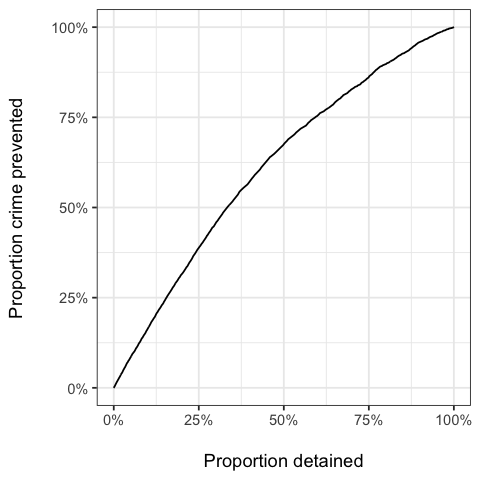

In [21]:
cost_benefit_df <- map_dfr(unique(compas_df$risk), 
                           ~ calc_cost_benefit(compas_df, .) %>%
                               mutate(threshold = .x))

# Plot proportion detained vs. proportion crime prevented
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(cost_benefit_df, aes(x=prop_detained, y=prop_crime_prevented)) +
    geom_line()+
    scale_y_continuous(labels = scales::percent_format(1), limits=c(0, 1))+
    scale_x_continuous(labels = scales::percent_format(1), limits=c(0, 1))+
    labs(x = "\nProportion detained",
         y = "Proportion crime prevented\n")

### Exercise 4: Disparities in detention

By conducting the above cost-benefit analysis,
we can decide on a detention threshold, say $0.5$, that we believe can maximize our benefit (crime prevention) at a acceptable cost of detaining some of the riskest defendants according to our model.

Now, we would like to know whether such a facially neutral policy, where we detain everyone with the same threshold, will introduce disparities across defendants of different races.

To do so, let's compute the dentention rate and recidivism rate for each racial group using a detention threshold of 0.5.

In [22]:
# Calculate detention and recidivism rate by race

# WRITE CODE HERE
# START solution
compas_df %>%
    mutate(detained = risk > 0.5) %>%
    group_by(race) %>%
    summarize(
        detention_rate = mean(detained),
        recidivism_rate = mean(is_recid * !detained)
    )
# END solution

race,detention_rate,recidivism_rate
<chr>,<dbl>,<dbl>
African-American,0.604,0.132
Caucasian,0.347,0.203


Despite the same detention threshold being used, we still observe a difference in dentention rate as well as in recidivism rate, suggesting a disparate impact against African-American defendents.

To further investigate, we can plot the distribution of risk for each of the two groups:

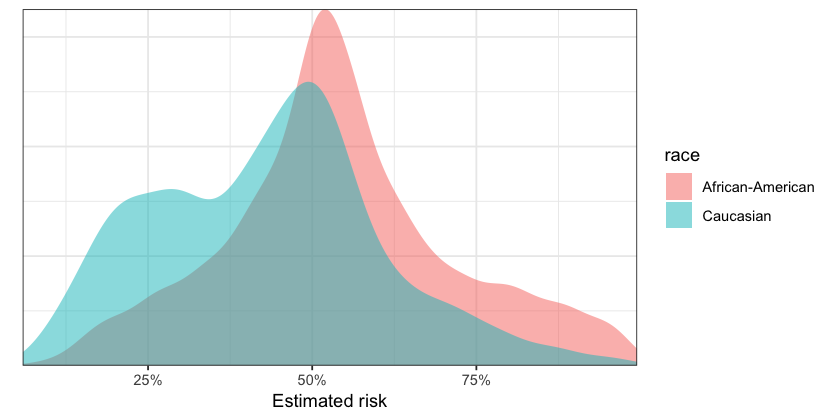

In [23]:
# Plot the risk distribution
options(repr.plot.width = 7, repr.plot.height = 3.5)
ggplot(compas_df, aes(x = risk, fill = race)) +
    geom_density(alpha = 0.5, color = NA) +
    scale_x_continuous("Estimated risk", labels = scales::percent_format(1), expand = c(0, 0)) +
    scale_y_continuous(element_blank(), expand = c(0, 0)) +
    theme(axis.ticks.y = element_blank(),
          axis.text.y = element_blank())

Assuming that our model provides an accurate assessment of risk, we see that African-American and Caucasian defendents do not share the same underlying risk distribution:
African-American defendants' risk distribution is more heavy-tailed on the higher end.
When we are making a policy decision, we are mostly concerned with what happens at the margin 
(e.g., whether the same standard is applied to all individuals).
What happens at the margin also determines whether decisions maximize social welfare,
with the optimal threshold set at the point where the marginal benefits equal the marginal costs.  However, popular error metrics assess behavior away from the margin, hence they are called infra-marginal statistics.
This general phenomenon is known as the problem of _infra-marginality_ (Ayres, 2002; Simoiu et al., 2017; Corbett-Davies and Goel, 2018).

### Exercise 5: A "fair" policy by equalizing detention rates?

<!--Realizing the problem of infra-marginality,
we are curious to see what a policy that equalizes the detention rate for each group will be like by applying different detention thrsholds to differrent group.-->
After observing the disparities in detention rate above, one natural thought might be to find a policy which equalizes detention rate across race groups.

In this exercise, play around with different thresholds for African-American and Caucasian defendants to achieve a detention rate of approximately 50% for each group.

In [24]:
black_threshold = 0.5
white_threshold = 0.5

# WRITE CODE HERE
# START solution
black_threshold = 0.53
white_threshold = 0.44
# END solution

# Calculate detention and recidivism rate by race
compas_df %>%
    mutate(detained = risk > if_else(race == "Caucasian", white_threshold, black_threshold)) %>%
    group_by(race) %>%
    summarize(
        detention_rate = mean(detained),
        recidivism_rate = mean(is_recid * !detained)
    )


race,detention_rate,recidivism_rate
<chr>,<dbl>,<dbl>
African-American,0.500,0.186
Caucasian,0.501,0.147


What are the threshold values that you find? Which policy would you consider "fair", and why?